# Machine Learning with the Hipparcos Star Catalog

Hipparcos Stellar Catalog from Kaggle https://www.kaggle.com/konivat/hipparcos-star-catalog

In [1]:
# Load packages and set the seaborn style
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition, preprocessing, model_selection
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE

## Train a model to classify stars depending on their variability type

In [2]:
# Load Hipparcos dataset
df0 = pd.read_csv("hipparcos-voidmain.csv")

# Take a subsample of the dataset with some features
df = df0[["Plx","Vmag","BTmag","VTmag","B-V","V-I","Hpmag","HvarType"]].copy()
# Remove rows with NaNs
df = df.dropna(axis=0)
df.head()

,Plx,Vmag,BTmag,VTmag,B-V,V-I,Hpmag,HvarType
1,21.90,9.27,10.519,9.378,0.999,1.04,9.4017,C
2,2.81,6.61,6.576,6.621,-0.019,0.00,6.6081,C
6,17.74,9.64,10.542,9.679,0.740,0.79,9.6795,C
7,5.17,9.05,10.433,9.151,1.102,3.92,8.5522,P
8,4.81,8.59,9.962,8.711,1.067,1.03,8.7534,C


In [3]:
df1 = df.drop(["HvarType"],axis=1).copy()
df1.head()

,Plx,Vmag,BTmag,VTmag,B-V,V-I,Hpmag
1,21.90,9.27,10.519,9.378,0.999,1.04,9.4017
2,2.81,6.61,6.576,6.621,-0.019,0.00,6.6081
6,17.74,9.64,10.542,9.679,0.740,0.79,9.6795
7,5.17,9.05,10.433,9.151,1.102,3.92,8.5522
8,4.81,8.59,9.962,8.711,1.067,1.03,8.7534


In [4]:
# Number of entries
df1.shape[0]

69490

In [5]:
# Show the different categories of variability and the number of rows of each one
df["HvarType"].value_counts()

C    45982
D    11593
U     7317
P     2455
R     1098
M     1045
Name: HvarType, dtype: int64

In [7]:
# Split-out validation dataset
X = df1.values
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
Y = df["HvarType"].astype('category').cat.codes
#Y = df["SpType"].astype('category').cat.codes
validation_size = 0.20
seed = 0
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed, stratify = Y)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((55592, 7), (13898, 7), (55592,), (13898,))

In [8]:
# Training routine
def train_model(X_train, X_test, Y_train, Y_test, model, verbose=False, **params):

    clf = model(**params)
    clf.fit(X_train,Y_train)
    predictions = clf.predict(X_test)
    acc_train, acc_test = accuracy_score(Y_train, clf.predict(X_train)), accuracy_score(Y_test, predictions)
    if verbose:
        print("Train accuracy: {:.2f}, Test accuracy: {:.2f}".format(acc_train, acc_test))
        print(confusion_matrix(Y_test, predictions))
        print(classification_report(Y_test, predictions))
    return acc_test

In [9]:
# Train the model performing a search
n_ests = range(10, 110, 10)

best_acc, best_nest = 0., 1
for n_est in n_ests:
    print("Random Forest, estimators:", n_est)
    acc_test = train_model(X_train, X_test, Y_train, Y_test, RandomForestClassifier, n_estimators=n_est)
    if acc_test>best_acc:
        best_acc = acc_test
        best_nest = n_est
        print("Test accuracy: {:.2f}".format(acc_test))
        
# Show results for the best model
print("Best model, estimators:", best_nest)
train_model(X_train, X_test, Y_train, Y_test, RandomForestClassifier, n_estimators=best_nest, verbose=True)

Random Forest, estimators: 10
Test accuracy: 0.71
Random Forest, estimators: 20
Test accuracy: 0.72
Random Forest, estimators: 30
Test accuracy: 0.72
Random Forest, estimators: 40
Test accuracy: 0.72
Random Forest, estimators: 50
Test accuracy: 0.72
Random Forest, estimators: 60
Random Forest, estimators: 70
Random Forest, estimators: 80
Test accuracy: 0.72
Random Forest, estimators: 90
Random Forest, estimators: 100
Best model, estimators: 80
Train accuracy: 1.00, Test accuracy: 0.72
[[8818  228   19   17    2  112]
 [1819  437    8   19    3   33]
 [ 118   14   36    7    0   34]
 [ 329   37    8   35    2   80]
 [ 131   35    1    1   35   17]
 [ 670   57   29   19    2  686]]
              precision    recall  f1-score   support

           0       0.74      0.96      0.84      9196
           1       0.54      0.19      0.28      2319
           2       0.36      0.17      0.23       209
           3       0.36      0.07      0.12       491
           4       0.80      0.16      0

0.7229097711900992

In [9]:
# Create a pipeline with a PCA and a random forest classifier
estimators = [('reduce_dim', decomposition.PCA()), ('randomforest', RandomForestClassifier())]
pipe = Pipeline(estimators)

# Create a grid search, considering different hyperparameters
param_grid = dict(reduce_dim__n_components=[3],randomforest__n_estimators=[30, 40, 50, 60, 70, 80], randomforest__max_depth=[10,20,30,None])
clf = GridSearchCV(pipe, param_grid=param_grid)
clf.fit(X_train, Y_train)
print(clf.best_params_)
predictions = clf.predict(X_test)
acc_train, acc_test = accuracy_score(Y_train, clf.predict(X_train)), accuracy_score(Y_test, predictions)

print("Train accuracy: {:.2f}, Test accuracy: {:.2f}".format(acc_train, acc_test))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

{'randomforest__max_depth': 10, 'randomforest__n_estimators': 70, 'reduce_dim__n_components': 3}
Train accuracy: 0.72, Test accuracy: 0.71
[[9129    4    7    0    0   56]
 [2260   34    6    1    0   18]
 [ 138    3   19    3    0   46]
 [ 407    0    6    2    0   76]
 [ 201    1    0    0    0   18]
 [ 783    4   16    2    0  658]]
              precision    recall  f1-score   support

           0       0.71      0.99      0.83      9196
           1       0.74      0.01      0.03      2319
           2       0.35      0.09      0.14       209
           3       0.25      0.00      0.01       491
           4       0.00      0.00      0.00       220
           5       0.75      0.45      0.56      1463

    accuracy                           0.71     13898
   macro avg       0.47      0.26      0.26     13898
weighted avg       0.68      0.71      0.61     13898



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
# Perform a PCA analysis to reduce dimensionality and visualize
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

/var/folders/mz/4m2hrcfn12l3j_lp6qbpkc6h0005hl/T/ipykernel_1512/3946126163.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


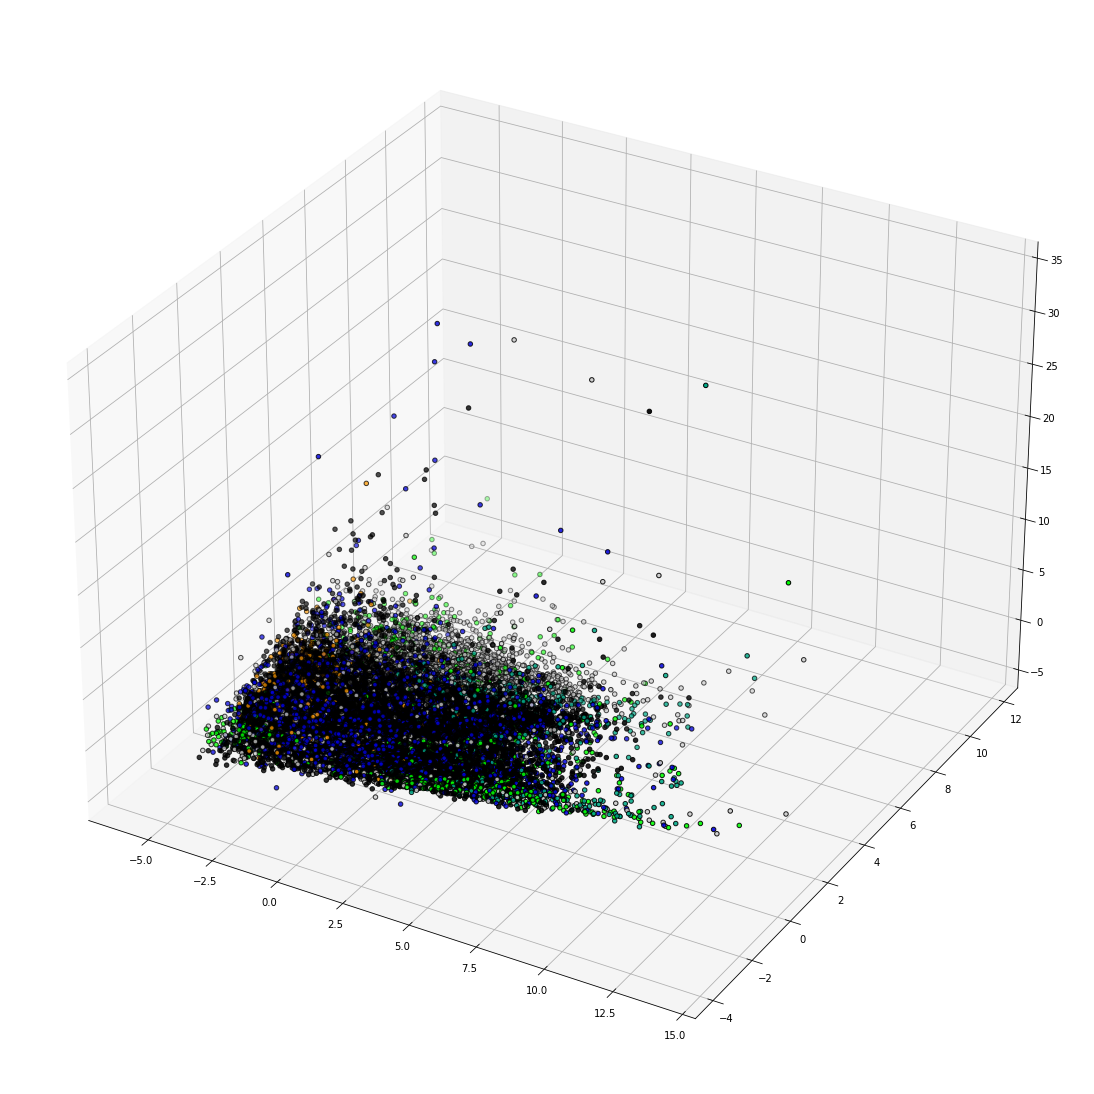

In [12]:
# Visualize principal components
fig = plt.figure(1, figsize=(15, 15))
plt.clf()
ax = Axes3D(fig)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=Y, cmap=plt.cm.nipy_spectral, edgecolor="k")
#plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.nipy_spectral, edgecolor="k")

## Predict now the spectral type of stars

In [13]:
# For predicting the spectral type, limit only to some categories with enough data
df = df0[["Plx","Vmag","BTmag","VTmag","B-V","V-I","Hpmag","SpType"]].copy()

df = df.dropna(axis=0)
categories = df["SpType"].unique()

# Take only those categories with at least 2500 entries
specs = categories[df["SpType"].value_counts(sort=False).values>2500]

# Build the new dataset with only these spectral types
dfspec = df[df["SpType"]==specs[0]]
for spec in specs[1:]:
    dfspec = dfspec.append(df[df["SpType"]==spec])
    
df = dfspec
df1 = df.drop(["SpType"],axis=1)

In [14]:
# Split-out validation dataset
X = df1.values
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
Y = df["SpType"].astype('category').cat.codes
validation_size = 0.20
seed = 0
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed, stratify = Y)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((35388, 7), (8848, 7), (35388,), (8848,))

In [16]:
# Try now with k-NN

n_ests = range(1,25)

best_acc, best_nest = 0., 1
for n_est in n_ests:
    print("Nearest neighbors, k:", n_est)
    acc_test = train_model(X_train, X_test, Y_train, Y_test, KNeighborsClassifier, n_neighbors=n_est)
    if acc_test>best_acc:
        best_acc = acc_test
        best_nest = n_est
        print("Test accuracy: {:.2f}".format(acc_test))
        
# Show results for the best model
print("Best model, k:", best_nest)
train_model(X_train, X_test, Y_train, Y_test, KNeighborsClassifier, n_neighbors=best_nest, verbose=True)

Nearest neighbors, k: 1
Test accuracy: 0.41
Nearest neighbors, k: 2
Test accuracy: 0.43
Nearest neighbors, k: 3
Test accuracy: 0.44
Nearest neighbors, k: 4
Test accuracy: 0.45
Nearest neighbors, k: 5
Test accuracy: 0.46
Nearest neighbors, k: 6
Test accuracy: 0.46
Nearest neighbors, k: 7
Test accuracy: 0.47
Nearest neighbors, k: 8
Test accuracy: 0.47
Nearest neighbors, k: 9
Test accuracy: 0.47
Nearest neighbors, k: 10
Test accuracy: 0.48
Nearest neighbors, k: 11
Test accuracy: 0.48
Nearest neighbors, k: 12
Test accuracy: 0.48
Nearest neighbors, k: 13
Nearest neighbors, k: 14
Test accuracy: 0.48
Nearest neighbors, k: 15
Test accuracy: 0.49
Nearest neighbors, k: 16
Nearest neighbors, k: 17
Nearest neighbors, k: 18
Nearest neighbors, k: 19
Test accuracy: 0.49
Nearest neighbors, k: 20
Test accuracy: 0.49
Nearest neighbors, k: 21
Test accuracy: 0.49
Nearest neighbors, k: 22
Test accuracy: 0.49
Nearest neighbors, k: 23
Nearest neighbors, k: 24
Test accuracy: 0.49
Best model, k: 24
Train accur

0.49005424954792043

In [17]:
# Now with a random forest

n_ests = range(10, 110, 10)

best_acc, best_nest = 0., 1
for n_est in n_ests:
    print("Random Forest, estimators:", n_est)
    acc_test = train_model(X_train, X_test, Y_train, Y_test, RandomForestClassifier, n_estimators=n_est)
    if acc_test>best_acc:
        best_acc = acc_test
        best_nest = n_est
        print("Test accuracy: {:.2f}".format(acc_test))
        
# Show results for the best model
print("Best model, estimators:", best_nest)
train_model(X_train, X_test, Y_train, Y_test, RandomForestClassifier, n_estimators=best_nest, verbose=True)

Random Forest, estimators: 10
Test accuracy: 0.46
Random Forest, estimators: 20
Test accuracy: 0.47
Random Forest, estimators: 30
Test accuracy: 0.48
Random Forest, estimators: 40
Random Forest, estimators: 50
Test accuracy: 0.48
Random Forest, estimators: 60
Test accuracy: 0.49
Random Forest, estimators: 70
Random Forest, estimators: 80
Random Forest, estimators: 90
Random Forest, estimators: 100
Best model, estimators: 60
Train accuracy: 1.00, Test accuracy: 0.48
[[767 181  28   2   2   2   1   0   0   0]
 [233 239  40   5   5   1   0   0   1   0]
 [  9  22 414 221  75  18   6   0   2   0]
 [  7   5 243 384 181  37   6   0   1   0]
 [  2   2  90 209 343 154  30   3   0   1]
 [  1   3  37  67 165 441 352  91  34   5]
 [  0   0   8  13  26 286 936 178 186  69]
 [  0   0   0   0   1  64 394 200  34   2]
 [  0   0   0   1   1  30 336  34 191 138]
 [  0   0   0   0   2   5  88   8 129 320]]
              precision    recall  f1-score   support

           0       0.75      0.78      0.77 

0.4786392405063291

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/var/folders/mz/4m2hrcfn12l3j_lp6qbpkc6h0005hl/T/ipykernel_1512/2829925629.py:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The 

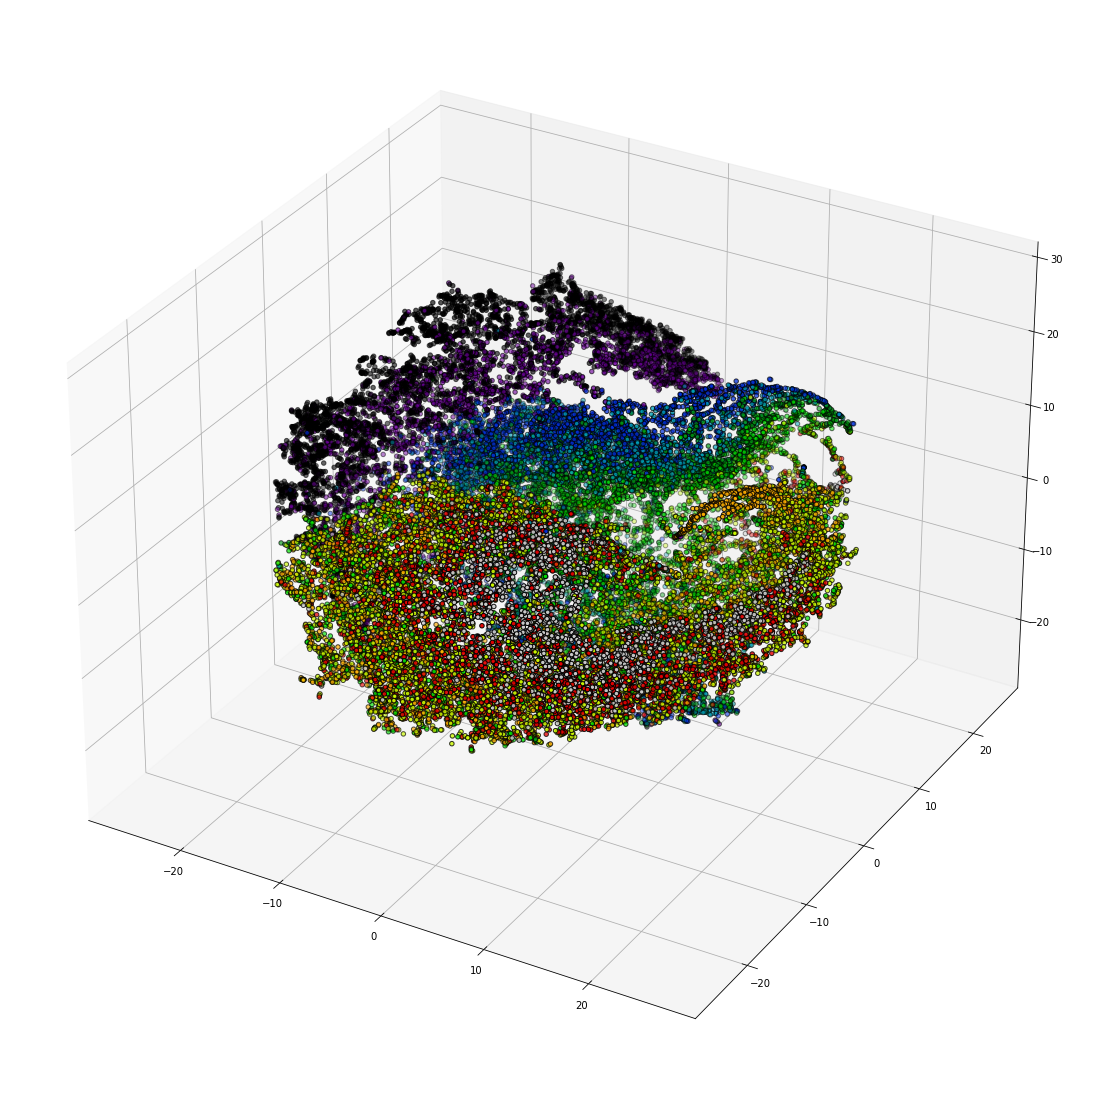

In [18]:
# Perform a t-SNE analysis to reduce dimensionality and visualize (it takes some time)
tsne = TSNE(n_components=3)
tsne.fit(X)
X = tsne.fit_transform(X)

# Visualize principal components
fig = plt.figure(1, figsize=(15, 15))
plt.clf()
ax = Axes3D(fig)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=Y, cmap=plt.cm.nipy_spectral, edgecolor="k")
#plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.nipy_spectral, edgecolor="k")

In [19]:
# Train now a random forest, with data previously transformed via t-SNE 
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed, stratify = Y)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

n_ests = range(10, 110, 10)

best_acc, best_nest = 0., 1
for n_est in n_ests:
    print("Random Forest, estimators:", n_est)
    acc_test = train_model(X_train, X_test, Y_train, Y_test, RandomForestClassifier, n_estimators=n_est)
    if acc_test>best_acc:
        best_acc = acc_test
        best_nest = n_est
        print("Test accuracy: {:.2f}".format(acc_test))
        
# Show results for the best model
print("Best model, estimators:", best_nest)
train_model(X_train, X_test, Y_train, Y_test, RandomForestClassifier, n_estimators=best_nest, verbose=True)

Random Forest, estimators: 10
Test accuracy: 0.45
Random Forest, estimators: 20
Test accuracy: 0.46
Random Forest, estimators: 30
Test accuracy: 0.46
Random Forest, estimators: 40
Test accuracy: 0.46
Random Forest, estimators: 50
Test accuracy: 0.46
Random Forest, estimators: 60
Random Forest, estimators: 70
Random Forest, estimators: 80
Random Forest, estimators: 90
Random Forest, estimators: 100
Best model, estimators: 50
Train accuracy: 1.00, Test accuracy: 0.46
[[774 176  23   6   0   3   1   0   0   0]
 [250 224  37   6   4   2   0   0   0   1]
 [ 17  19 384 238  81  21   6   0   1   0]
 [  6   5 242 360 191  50   7   1   1   1]
 [  6   2  89 217 309 164  38   5   3   1]
 [  1   5  36  61 169 427 359  96  34   8]
 [  0   0   8  16  35 289 846 235 199  74]
 [  1   0   0   0   1  84 375 195  35   4]
 [  0   0   1   0   3  37 307  39 205 139]
 [  1   0   0   0   1   5  92  10 133 310]]
              precision    recall  f1-score   support

           0       0.73      0.79      0.76 

0.4559222423146474